In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import mode
import copy
from ipynb.fs.full.PlotData import basic_map

In [2]:
t2m_files = ["/home/data/ERA5/day/t2m/t2m_{}.nc".format(i) for i in range(1979, 2020)]
t2m = xr.open_mfdataset(t2m_files).load()

In [5]:
all_lats = t2m.lat.data
all_lons = t2m.lon.data

In [6]:
extent = [-130, -65, 25, 65]
extent_lats, extent_lons = [], []

for lat in all_lats:
    if lat >= 25 and lat <= 65:
        print(lat)
        extent_lats.append(lat)
        
for lon in all_lons:
    if lon >= (-130+360) and lon <= (-65+360):
        print(lon)
        extent_lons.append(lon)

25.916230366492144
26.8586387434555
27.801047120418843
28.7434554973822
29.685863874345543
30.6282722513089
31.570680628272257
32.5130890052356
33.455497382198956
34.3979057591623
35.340314136125656
36.282722513089
37.225130890052355
38.16753926701571
39.10994764397907
40.0523560209424
40.994764397905755
41.93717277486911
42.87958115183247
43.8219895287958
44.764397905759154
45.70680628272251
46.64921465968587
47.591623036649224
48.53403141361255
49.47643979057591
50.41884816753927
51.36125654450262
52.30366492146598
53.24607329842931
54.188481675392666
55.13089005235602
56.07329842931938
57.01570680628271
57.958115183246065
58.90052356020942
59.84293193717278
60.785340314136135
61.727748691099464
62.67015706806282
63.61256544502618
64.55497382198953
230.0
231.25
232.5
233.75
235.0
236.25
237.5
238.75
240.0
241.25
242.5
243.75
245.0
246.25
247.5
248.75
250.0
251.25
252.5
253.75
255.0
256.25
257.5
258.75
260.0
261.25
262.5
263.75
265.0
266.25
267.5
268.75
270.0
271.25
272.5
273.75
275.0

In [20]:
us_np_lons = np.tile(all_lons,len(all_lats))
us_np_lats = np.repeat(all_lats,len(all_lons))

In [21]:
def get_bootstrapped_xr(values, modes,lats,lons,percent_consistent=0.95):
    consistent = []
    for i,row in enumerate(values): 
        # if 950 or more values in this lat lon spot match the mode, then its consistent
        consistent.append(np.sum(row == modes[i]) >= percent_consistent*1000)
        
    # turn the not consistent lat,lon spots to np.nan
    modes[~np.array(consistent)] = np.nan
    
    df = pd.DataFrame({'corrs':modes, 'lat':lats, 'lon':lons})
    
    return(df.set_index(['lat', 'lon']).to_xarray())

In [8]:
us_vals_1dbf = np.loadtxt("/home/dhruv/data/bootstrap/US_1db4_hwdays.txt") 

# find modes
us_modes_1dbf = np.apply_along_axis(mode,1,us_vals_1dbf)
us_modes_1dbf = us_modes_1dbf[:,0,0]

In [16]:
len(us_modes_1dbf)

55296

In [22]:
len(us_np_lats)

55296

In [41]:
us_corr_xr_1dbf = get_bootstrapped_xr(us_vals_1dbf, us_modes_1dbf, us_np_lats, us_np_lons, percent_consistent=0)

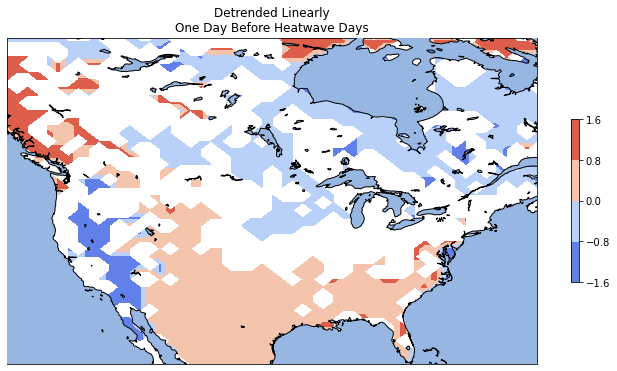

In [45]:
basic_map(-1*us_corr_xr_1dbf.corrs,title="Detrended Linearly\nOne Day Before Heatwave Days")

In [46]:
us_vals_1dbf = np.loadtxt("/home/dhruv/data/bootstrap/US_1db4_hwdays.txt") 

us_modes_1dbf = np.apply_along_axis(mode,1,us_vals_1dbf)
us_modes_1dbf = us_modes_1dbf[:,0,0]
hatching_1dbf = np.full((len(us_modes_1dbf)),0)

In [47]:
us_consistent_1dbf = []
for i,row in enumerate(us_vals_1dbf): 
    # if 950 or more values in this lat lon spot match the mode, then its consistent
    us_consistent_1dbf.append(np.sum(row ==us_modes_1dbf[i]) >= 950)

In [48]:
hatching_1dbf[~np.array(us_consistent_1dbf)] = 1

In [49]:
df_1dbf = pd.DataFrame({'corrs':us_modes_1dbf, 'lat':us_np_lats, 'lon':us_np_lons})
us_corr_xr_1dbf = df_1dbf.set_index(['lat', 'lon']).to_xarray()

df_hatch_1dbf = pd.DataFrame({'hatches':hatching_1dbf, 'lat':us_np_lats, 'lon':us_np_lons})
us_hatch_xr_1dbf = df_hatch_1dbf.set_index(['lat', 'lon']).to_xarray()

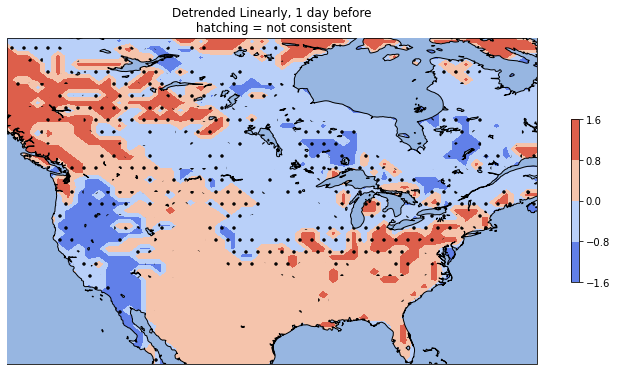

In [51]:
#plt.pcolor(us_hatch_xr_1dbf.lon,us_hatch_xr_1dbf.lat,us_hatch_xr_1dbf.hatches, hatch='x',zorder=4 )
basic_map(-1*us_corr_xr_1dbf.corrs,title='Detrended Linearly, 1 day before\n hatching = not consistent')

# add hatching
plt.contourf(us_hatch_xr_1dbf.lon, us_hatch_xr_1dbf.lat, us_hatch_xr_1dbf.hatches ,1,
             hatches=[None,'.'],colors='None')
